In [1]:
from configs import CFG1, TextBoxCFG, ImageCFG, Point
from generators import create_image
from generation_utils import split_sentence, get_tiled_option_cfgs

In [2]:
import pandas as pd

messages = pd.read_csv("texts/message_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, names.shape

((14, 5), (10, 5))

<ruby>猿辺川<rt>さるへんかわ</rt></ruby>の<ruby>下流<rt>かりゅう</rt></ruby>の<ruby>石寺<rt>いしでら</rt></ruby>と<ruby>西側<rt>にしがわ</rt></ruby>の<ruby>梅戸城<rt>うめとじょう</rt></ruby>は、<ruby>我<rt>われ</rt></ruby>らの<ruby>領分<rt>りょうぶん</rt></ruby>です。しかし<ruby>此方<rt>こちら</rt></ruby>は<ruby>武田<rt>たけだ</rt></ruby>の<ruby>軍門<rt>ぐんもん</rt></ruby>に降りました
ジョアキム・ウィリアム・ラッセル
酢漬けか。
<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが
<ruby>静香<rt>しずか</rt></ruby>さん、さっきまでここにいたみたいだけれど
<ruby>血統書<rt>けっとうしょ</rt></ruby>付きの<ruby>子牛<rt>こうし</rt></ruby>は、<ruby>王家<rt>おうけ</rt></ruby>の<ruby>宝<rt>たから</rt></ruby>だからね。
<ruby>貧乏神<rt>びんぼうかみ</rt></ruby>と<ruby>喧嘩<rt>けんか</rt></ruby>しても、どうせ負けるから。
<ruby>精麦<rt>せいばく</rt></ruby>も出来るし、<ruby>精酒<rt>せいしゅ</rt></ruby>にもできる。
<ruby>辺鄙<rt>へんぴ</rt></ruby>で、<ruby>人族<rt>ひとぞく</rt></ruby>は住めない<ruby>地域<rt>ちいき</rt></ruby>ですが......それでも『<ruby>精霊<rt>せいれい</rt></ruby>の<ruby>森<rt>もり</rt></ruby>』と呼ばれています


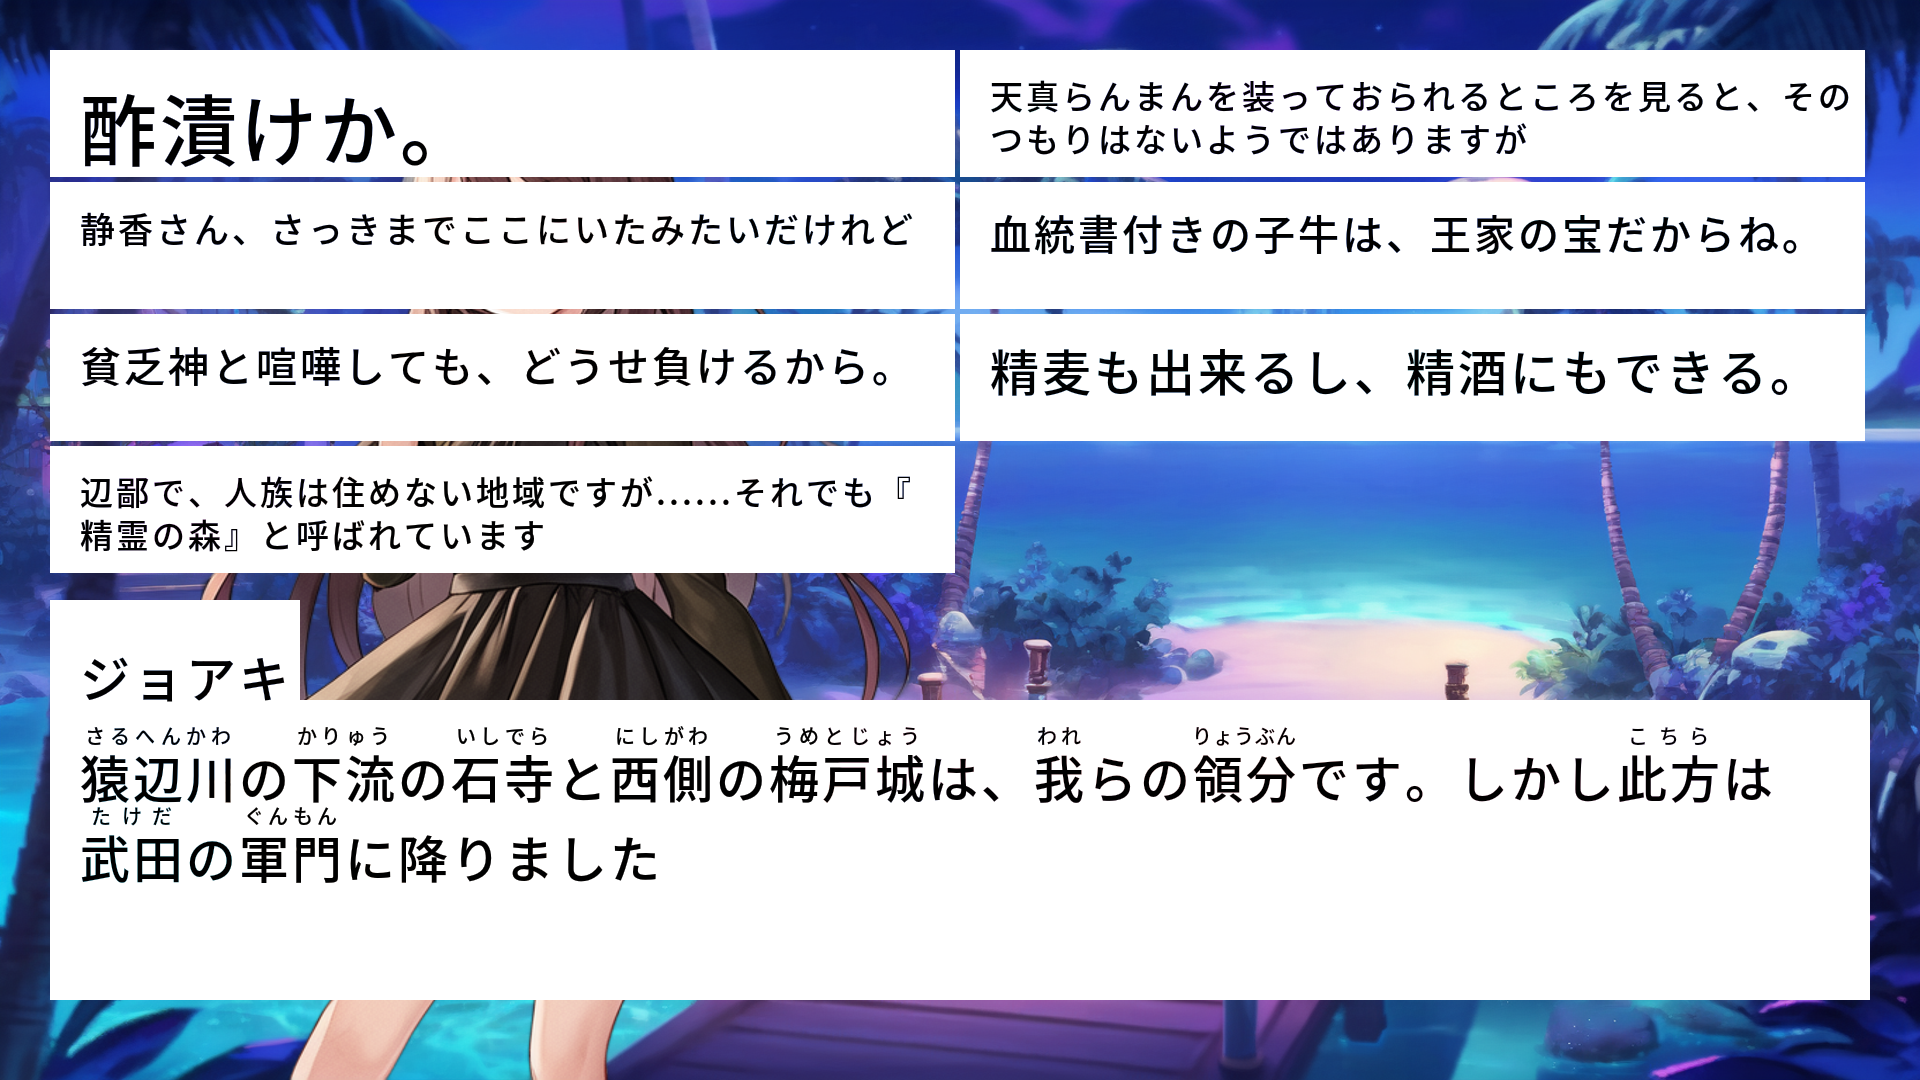

In [9]:
cfg = CFG1()

# 背景画像
cfg.bg_cfg = ImageCFG(path="./sample_images/sample_bg.png")

# キャラクター画像
cfg.character_cfg_list = [
    ImageCFG(path="./sample_images/sample_character.png", tl=Point(200, 0))
    ]

# メッセージ
text = messages.sample(1)["text_ruby_hiragana"].values[0]
cfg.msgbox.text = text
cfg.msgbox.tl = Point(50, 700)
cfg.msgbox.br = Point(1870, 1000)
print(text)

# 名前
name_text = names.sample(1)["text_ruby_hiragana"].values[0]
cfg.namebox.text = name_text
cfg.namebox.tl = Point(50, 600)
cfg.namebox.br = Point(300, 600 + cfg.namebox.minheight)
print(name_text)

# 選択肢
optionbox_list = []
for i in range(7):
    option_text = split_sentence(messages.sample(1)["text_ruby_hiragana"].values[0])[0]
    # option_text = split_sentence(messages.iloc[[i]]["text_ruby_hiragana"].values[0])[0]
    option_cfg = TextBoxCFG()
    option_cfg.text = option_text
    option_cfg.change_font_size(25)
    option_cfg.has_ruby = False
    option_cfg.tl = Point(300, 200)
    option_cfg.br = Point(1620, 200 + option_cfg.minheight*5)
    print(option_text)
    optionbox_list.append(option_cfg)
cfg.optionbox_list = get_tiled_option_cfgs(
    nrow=4, ncol=2, tl=Point(x=50, y=50), br=Point(x=1870, y=580), cfgs=optionbox_list
    )
output = create_image(cfg)

display(output.image)

In [4]:
output.name_text, output.text, output.option_texts

('ローレン',
 '<ruby>猿辺川<rt>さるへんかわ</rt></ruby>の<ruby>下流<rt>かりゅう</rt></ruby>の<ruby>石寺<rt>いしでら</rt></ruby>と<ruby>西側<rt>にしがわ</rt></ruby>の<ruby>梅戸城<rt>うめとじょう</rt></ruby>は、<ruby>我<rt>われ</rt></ruby>らの<ruby>領分<rt>りょうぶん</rt></ruby>です。しかし<ruby>此方<rt>こちら</rt></ruby>は<ruby>武田<rt>たけだ</rt></ruby>の<ruby>軍門<rt>ぐんもん</rt></ruby>に降りました',
 ['<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが',
  '<ruby>静香<rt>しずか</rt></ruby>さん、さっきまでここにいたみたいだけれど',
  '<ruby>静謐<rt>せいひつ</rt></ruby>の<ruby>魔導具<rt>まどうぐ</rt></ruby>は<ruby>魔法力<rt>まほうりょく</rt></ruby>を通すことで、その<ruby>場<rt>ば</rt></ruby>の<ruby>空気<rt>くうき</rt></ruby>を<ruby>振動<rt>しんどう</rt></ruby>させる'])

In [5]:
# from generation_utils import remove_ruby_tags
# remove_ruby_tags("<ruby>貧乏神<rt>びんぼうかみ</rt></ruby>と<ruby>喧嘩<rt>けんか</rt></ruby>しても、どうせ負けるから。")